<a href="https://colab.research.google.com/github/Eyang1113/CNN/blob/main/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import json
from torchsummary import summary
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
import cv2
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

In [ ]:
image_size = 224
batch_size = 32
num_workers = 2
learning_rate = 1e-4
num_epoch = 10

In [ ]:
train_set = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/balls/train', transform=transforms.Compose([transforms.Resize((image_size, image_size)),
                                                                                                  transforms.RandomRotation(30),
                                                                                                  transforms.ToTensor()]))

test_set = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/balls/test', transform=transforms.Compose([transforms.Resize((image_size, image_size)),
                                                                                                  transforms.ToTensor()]))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

In [ ]:
def count_samples_per_class(dataset):
    labels = [label for _, label in dataset]
    label_count = Counter(labels)
    return label_count

label_count = count_samples_per_class(test_set)
num_classes = len(label_count)
print("Total number of data: ", len(test_set))
print("Number of classes:", num_classes)
print("Number of data samples per class:", label_count)

Total number of data:  311
Number of classes: 5
Number of data samples per class: Counter({3: 68, 1: 66, 4: 64, 2: 63, 0: 50})


In [ ]:
cat_to_name = {'0': 'Baseball', '1': 'Basketball', '2': 'Shuttlecock', '3': 'Tennis_Ball', '4': 'Volleyball'}

def imshow(img_tensor, ax, label):
    """ Utility function to display an image tensor with a caption. """
    if img_tensor.shape[0] == 3:
        ax.imshow(img_tensor.permute(1, 2, 0))
    else:
        ax.imshow(img_tensor[0], cmap='gray')
    ax.axis('off')
    ax.set_title(label, fontsize=10)

def show_images_batch(images_batch, labels):
    """
    Display a batch of images in a grid with labels.
    """

    batch_size = images_batch.shape[0]
    grid_cols = int(np.ceil(np.sqrt(batch_size)))
    grid_rows = int(np.ceil(batch_size / grid_cols))

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2.5, grid_rows * 2.5))
    if grid_rows * grid_cols == 1:
        axes = [axes]

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])


    for i in range(grid_rows * grid_cols):
        ax = axes.flatten()[i]
        if i < batch_size:
            imshow(images_batch[i], ax, cat_to_name[str(labels[i].item())])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

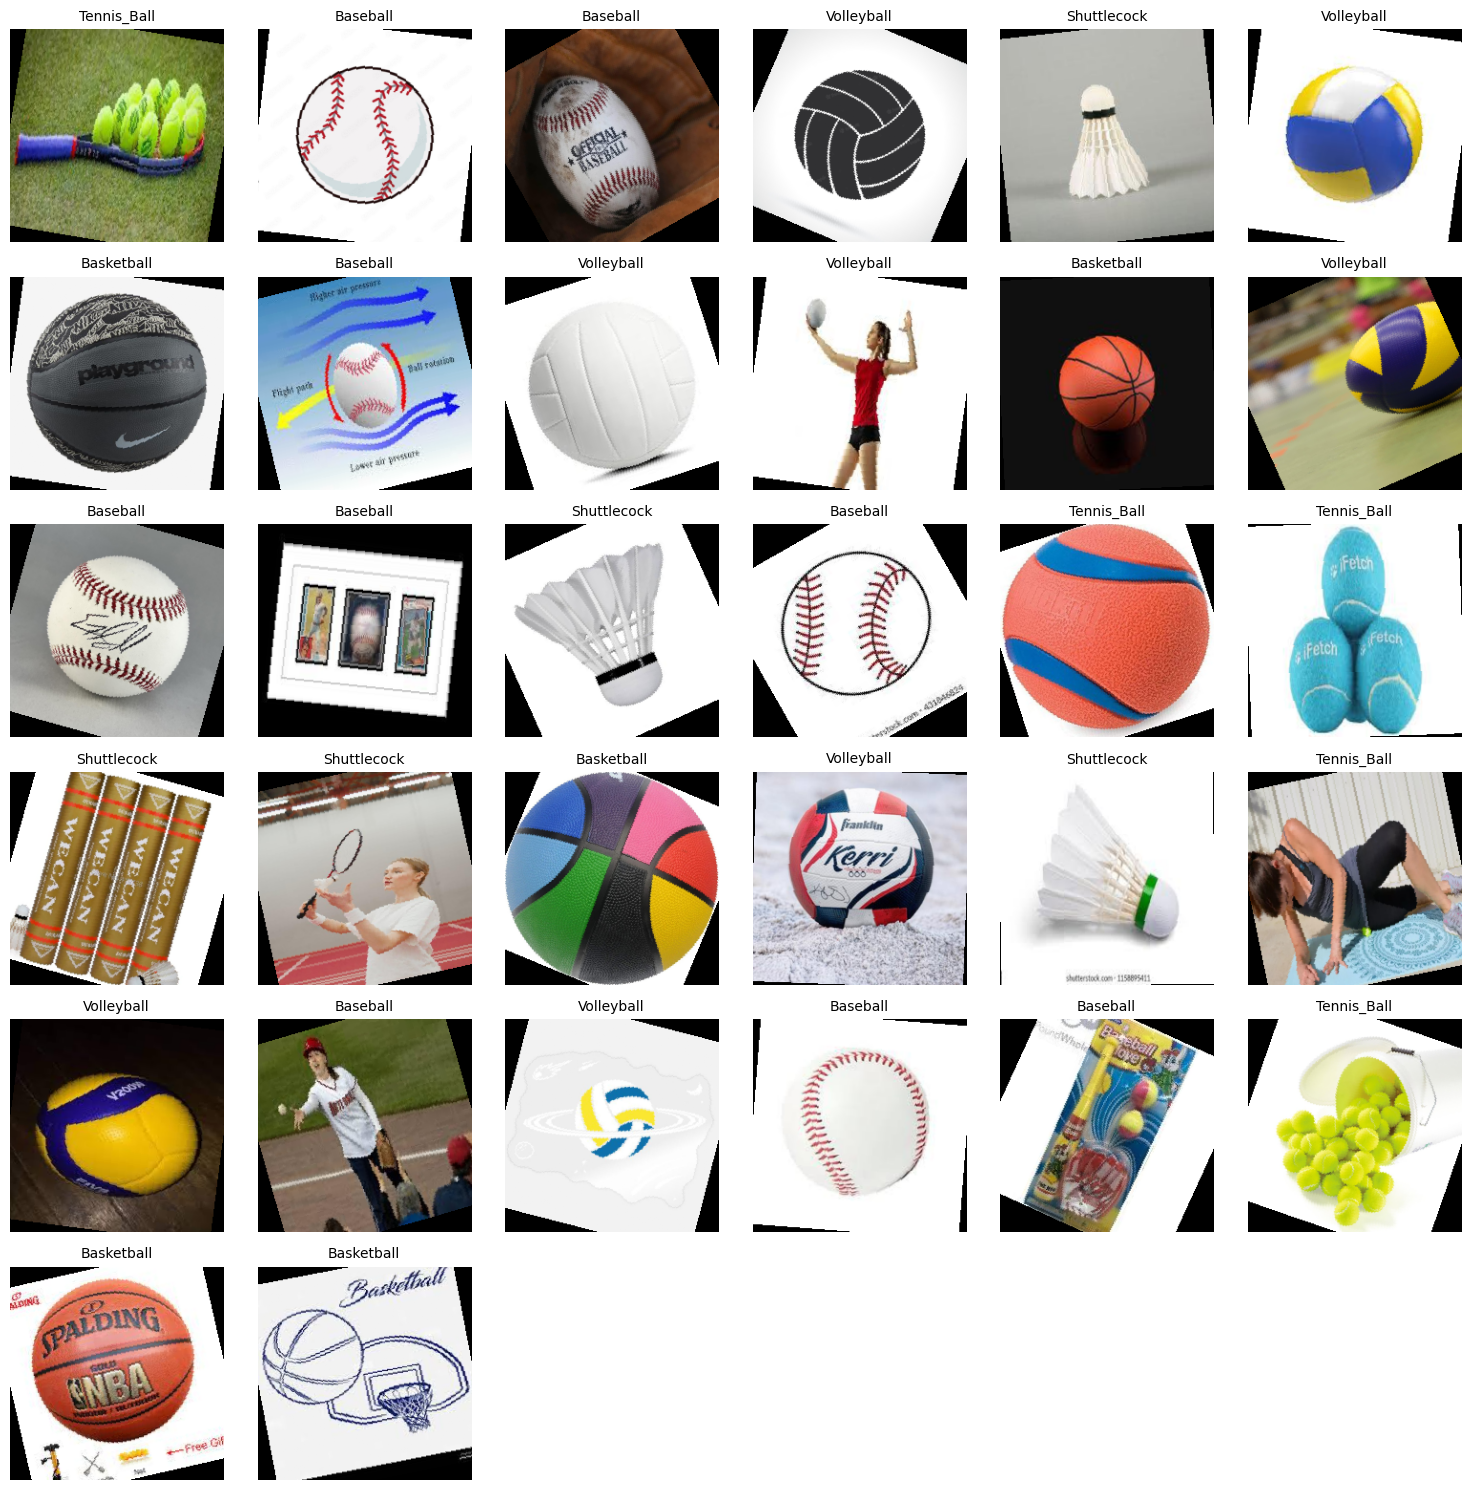

In [ ]:
for idx, data in enumerate(train_loader):
  show_images_batch(images_batch=data[0], labels=data[1])
  break

# CNN Model

In [ ]:
vgg_model = torchvision.models.vgg11(weights='IMAGENET1K_V1').cuda()

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:04<00:00, 116MB/s]


In [ ]:
summary(vgg_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

## Chnage Output Layer

In [ ]:
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vgg_model.parameters(), lr=learning_rate)

# Change the output layer according to the number of classes
vgg_model.classifier[6] = nn.Linear(4096, num_classes)

vgg_model = vgg_model.cuda()

In [ ]:
for n, p in vgg_model.named_parameters():
  print(n)

features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.11.weight
features.11.bias
features.13.weight
features.13.bias
features.16.weight
features.16.bias
features.18.weight
features.18.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [ ]:
for p in vgg_model.named_parameters():
  if 'classifier' in p[0]:
    p[1].requires_grad = True

In [ ]:
summary(vgg_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

## Retrain The Model

In [ ]:
best_val_accuracy = 0

train_loss_history = {}
train_accuracy_history = {}

for epoch_idx in range(num_epoch):

  train_running_loss = 0.0
  train_running_accuracy = 0.0

  idx = 0
  for idx, data in tqdm(enumerate(train_loader)):

    optimizer.zero_grad()

    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    pred = vgg_model(images)

    loss = loss_fn(pred, labels)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()

    train_loss_history[epoch_idx] = train_running_loss
    train_accuracy_history[epoch_idx] = train_running_accuracy/(idx+1)

    train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())


  print(f"Training Loss at epoch {epoch_idx} is {train_running_loss}")
  print(f"Training Accuracy at epoch {epoch_idx} is {train_running_accuracy/(idx+1)}")

24it [01:43,  4.30s/it]

Training Loss at epoch 0 is 24.213778644800186
Training Accuracy at epoch 0 is 0.5825272817460317



24it [00:08,  2.74it/s]

Training Loss at epoch 1 is 9.51583145558834
Training Accuracy at epoch 1 is 0.8547247023809524



24it [00:10,  2.24it/s]

Training Loss at epoch 2 is 5.614505689591169
Training Accuracy at epoch 2 is 0.9133184523809524



24it [00:09,  2.57it/s]

Training Loss at epoch 3 is 3.3110841093584895
Training Accuracy at epoch 3 is 0.953125



24it [00:10,  2.38it/s]

Training Loss at epoch 4 is 1.6805853587575257
Training Accuracy at epoch 4 is 0.98046875



24it [00:11,  2.07it/s]

Training Loss at epoch 5 is 1.1615443746559322
Training Accuracy at epoch 5 is 0.9856770833333334



24it [00:08,  2.73it/s]

Training Loss at epoch 6 is 0.4899092094274238
Training Accuracy at epoch 6 is 0.99609375



24it [00:12,  2.00it/s]

Training Loss at epoch 7 is 1.2060278019926045
Training Accuracy at epoch 7 is 0.9908854166666666



24it [00:11,  2.12it/s]

Training Loss at epoch 8 is 1.0802094673272222
Training Accuracy at epoch 8 is 0.9817708333333334



24it [00:09,  2.47it/s]

Training Loss at epoch 9 is 1.048197333875578
Training Accuracy at epoch 9 is 0.9869791666666666


In [ ]:
test_running_loss = 0.0
test_running_accuracy = 0.0
idx = 0
for idx, data in enumerate(test_loader):


  images, labels = data
  images = images.cuda()
  labels = labels.cuda()

  pred = vgg_model(images)

  loss = loss_fn(pred, labels)

  test_running_loss += loss.item()

  _, pred_arr = torch.max(pred.detach(), 1)
  label_arr = labels.cpu().numpy()

  test_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  if idx == 10:
    break


print(f"testidation Loss is {test_running_loss}")
print(f"testidation Accuracy is {test_running_accuracy/(idx+1)}")

testidation Loss is 3.757522404193878
testidation Accuracy is 0.8794836956521739


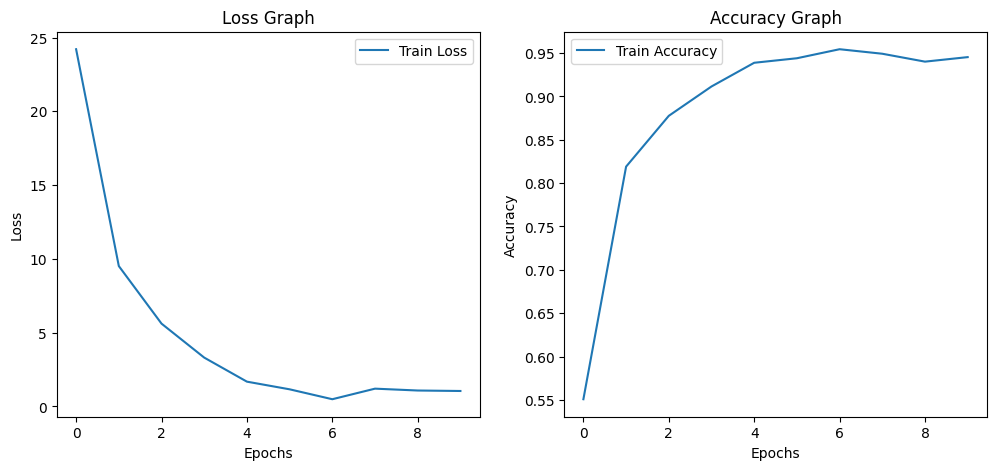

In [ ]:
plt.figure(num=2, figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(train_loss_history.keys()), list(train_loss_history.values()), label='Train Loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(list(train_accuracy_history.keys()), list(train_accuracy_history.values()), label='Train Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

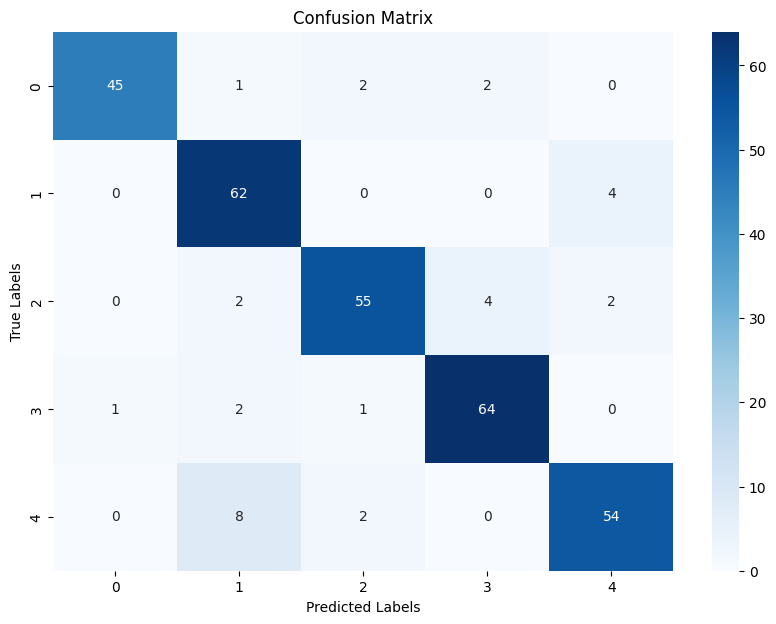

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

# Initialize lists to store all predictions and ground truth labels
all_preds = []
all_labels = []

vgg_model.eval()
vgg_model = vgg_model.cuda()

# After testing the model, gather all predictions and true labels
with torch.no_grad():
    for idx, data in enumerate(test_loader):
        images, labels = data

        images = images.cuda()
        labels = labels.cuda()

        # Model inference
        pred = vgg_model(images)
        _, pred_arr = torch.max(pred.detach(), 1)

        # Store predictions and labels for confusion matrix
        all_preds.extend(pred_arr.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
torch.save(vgg_model.state_dict(), 'balls_classification.pth')